In [23]:
# ============================================================================
# LIMPEZA DE KERNEL - Remove variáveis antigas para evitar conflitos
# ============================================================================
# Isso garante que mudanças no booleano USE_NORMALIZATION sejam aplicadas corretamente
import sys
for var in list(globals().keys()):
    if var not in ['__builtins__', '__name__', '__doc__', '__package__', '__loader__', '__spec__', '__annotations__', '__cached__', 'sys']:
        del globals()[var]
print("✓ Kernel limpo - variáveis antigas removidas\n")

✓ Kernel limpo - variáveis antigas removidas



In [24]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import os

# ============================================================================
# PAINEL DE CONTROLE - Configurações Booleanas
# ============================================================================
USE_FILTER = True              # Aplicar filtro Butterworth?
USE_DATA_NORMALIZATION = True  # Normalizar dados por canal (z-score)?
USE_NORMALIZATION = False      # Normalizar dados para o plot?
SAVE_FIGURES = True            # Salvar figuras em PNG?
SHOW_PLOTS = True              # Exibir gráficos no notebook?

# ============================================================================
# CONFIGURAÇÕES DO PROCESSAMENTO
# ============================================================================
# Usar caminho absoluto para o projeto CNN_vs_CSP
PROJECT_ROOT = Path(r"C:\Users\Chari\Documents\Obsidian Vault\CNN_vs_CSP")
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "patients"
FIGURES_DIR = PROJECT_ROOT / "figures"
PATIENT_ID = 2                 # ID do paciente para processar
SAMPLING_RATE = 250            # Hz
FILTER_LOW = 8                 # Hz (para motor imagery)
FILTER_HIGH = 30               # Hz
FILTER_ORDER = 3               # Ordem do filtro Butterworth

# Configurações de visualização
CHANNELS_TO_PLOT = ['EEG-C3', 'EEG-Cz', 'EEG-C4']
NUM_TRIALS_TO_PLOT = 6
FIG_DPI = 500
FIG_FORMAT = 'png'

# ============================================================================
# Exibir configurações ativas
# ============================================================================
print("╔═══════════════════════════════════════════════════════╗")
print("║          CONFIGURAÇÕES ATIVAS DO PIPELINE            ║")
print("╠═══════════════════════════════════════════════════════╣")
print(f"║ Filtro Butterworth: {'✓ ATIVO' if USE_FILTER else '✗ DESATIVADO':.<40} ║")
print(f"║ Normalização de dados: {'✓ ATIVA' if USE_DATA_NORMALIZATION else '✗ DESATIVADA':.<32} ║")
print(f"║ Normalização de plot: {'✓ ATIVA' if USE_NORMALIZATION else '✗ DESATIVADA':.<33} ║")
print(f"║ Salvar figuras: {'✓ SIM' if SAVE_FIGURES else '✗ NÃO':.<47} ║")
print(f"║ Mostrar plots: {'✓ SIM' if SHOW_PLOTS else '✗ NÃO':.<49} ║")
print(f"║ Banda de frequência: {FILTER_LOW}-{FILTER_HIGH} Hz (Ordem: {FILTER_ORDER})            ║")
print("╚═══════════════════════════════════════════════════════╝\n")
print(f"📁 Diretório de dados: {DATA_DIR}")
print(f"📁 Diretório de figuras: {FIGURES_DIR}\n")

╔═══════════════════════════════════════════════════════╗
║          CONFIGURAÇÕES ATIVAS DO PIPELINE            ║
╠═══════════════════════════════════════════════════════╣
║ Filtro Butterworth: ✓ ATIVO................................. ║
║ Normalização de dados: ✓ ATIVA......................... ║
║ Normalização de plot: ✗ DESATIVADA..................... ║
║ Salvar figuras: ✓ SIM.......................................... ║
║ Mostrar plots: ✓ SIM............................................ ║
║ Banda de frequência: 8-30 Hz (Ordem: 3)            ║
╚═══════════════════════════════════════════════════════╝

📁 Diretório de dados: C:\Users\Chari\Documents\Obsidian Vault\CNN_vs_CSP\data\raw\patients
📁 Diretório de figuras: C:\Users\Chari\Documents\Obsidian Vault\CNN_vs_CSP\figures



In [25]:
# Load and prepare data
file_path = DATA_DIR / f"BCICIV_2a_{PATIENT_ID}.csv"
df_original = pd.read_csv(file_path)
df_original["time"] = df_original["time"].astype(float)

# Filter for RIGHT and LEFT labels
df_filtered_labels = df_original[df_original['label'].isin(['right', 'left'])].copy()
df_filtered_labels = df_filtered_labels.sort_values('time').reset_index(drop=True)

eeg_columns = [col for col in df_filtered_labels.columns if col.startswith('EEG-')]
print(f"✓ Carregadas {len(df_filtered_labels)} amostras, {len(eeg_columns)} canais EEG")
print(f"✓ Trials: {df_filtered_labels['label'].value_counts().to_dict()}")

✓ Carregadas 28944 amostras, 22 canais EEG
✓ Trials: {'right': 14472, 'left': 14472}


In [26]:
# ============================================================================
# Função de normalização (z-score por canal)
# ============================================================================
def normalize_eeg_channel(data, mean=None, std=None):
    """
    Normaliza canal EEG usando z-score
    Se mean e std são fornecidos, usa esses valores (para normalizar com base no dataset inteiro)
    Caso contrário, calcula usando a série atual
    """
    if mean is None or std is None:
        mean = np.mean(data)
        std = np.std(data)
    
    if std == 0:
        return data - mean
    return (data - mean) / (std + 1e-8)  # 1e-8 para evitar divisão por zero

# ============================================================================
# Bandpass filter function and apply
# ============================================================================
def bandpass_filter(series, lowcut=FILTER_LOW, highcut=FILTER_HIGH, fs=SAMPLING_RATE, order=FILTER_ORDER):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, (low, high), btype="band")
    return signal.filtfilt(b, a, series)

# ============================================================================
# Organize trials, apply filter and normalization
# ============================================================================
trials = {}
normalization_stats = {}  # Armazenar mean/std de cada canal para consistência

# First pass: calcular estatísticas globais para normalização (se USE_DATA_NORMALIZATION)
if USE_DATA_NORMALIZATION:
    print("ℹ Calculando estatísticas globais para normalização...")
    for col in eeg_columns:
        all_data = []
        for epoch_id in sorted(df_filtered_labels['epoch'].unique()):
            trial_data = df_filtered_labels[df_filtered_labels['epoch'] == epoch_id].copy()
            if len(trial_data) > 0:
                # Aplicar filtro aos dados originais para cálculo de stats
                if USE_FILTER:
                    filtered_values = bandpass_filter(trial_data[col].values)
                else:
                    filtered_values = trial_data[col].values
                all_data.extend(filtered_values)
        
        # Calcular mean e std globais
        all_data = np.array(all_data)
        normalization_stats[col] = {
            'mean': np.mean(all_data),
            'std': np.std(all_data)
        }

# Second pass: aplicar filtro e normalização
for epoch_id in sorted(df_filtered_labels['epoch'].unique()):
    trial_data = df_filtered_labels[df_filtered_labels['epoch'] == epoch_id].copy()
    if len(trial_data) > 0:
        label = trial_data['label'].iloc[0]
        
        # Apply filter to all EEG channels
        for col in eeg_columns:
            if USE_FILTER:
                trial_data[col + '_filtered'] = bandpass_filter(trial_data[col].values)
            else:
                trial_data[col + '_filtered'] = trial_data[col].values
            
            # Apply normalization after filtering
            if USE_DATA_NORMALIZATION:
                stats = normalization_stats[col]
                trial_data[col + '_normalized'] = normalize_eeg_channel(
                    trial_data[col + '_filtered'].values, 
                    mean=stats['mean'], 
                    std=stats['std']
                )
        
        trials[epoch_id] = {
            'data': trial_data,
            'label': label,
            'samples': len(trial_data)
        }

if USE_FILTER:
    print(f"✓ Filtro Butterworth {FILTER_ORDER}ª ordem ({FILTER_LOW}-{FILTER_HIGH} Hz) aplicado")
else:
    print(f"ℹ Filtro DESATIVADO - usando dados originais")

if USE_DATA_NORMALIZATION:
    print(f"✓ Normalização (z-score) aplicada em cada canal")
else:
    print(f"ℹ Normalização de dados DESATIVADA")

print(f"✓ Total de trials: {len(trials)}")

ℹ Calculando estatísticas globais para normalização...
✓ Filtro Butterworth 3ª ordem (8-30 Hz) aplicado
✓ Normalização (z-score) aplicada em cada canal
✓ Total de trials: 144


In [27]:
# Prepare visualizations
right_trials = [e for e, info in trials.items() if info['label'] == 'right']
left_trials = [e for e, info in trials.items() if info['label'] == 'left']

num_trials = NUM_TRIALS_TO_PLOT
channels_to_plot = CHANNELS_TO_PLOT

# Definir qual coluna usar para análise
analysis_column_suffix = '_normalized' if USE_DATA_NORMALIZATION else '_filtered'

# Compute mean trials
def compute_mean_trial(trial_ids, label_target):
    trial_list = [trials[e]['data'] for e in trial_ids if trials[e]['label'] == label_target]
    if trial_list:
        all_data = np.array([trial[[col + analysis_column_suffix for col in eeg_columns]].values for trial in trial_list])
        return all_data.mean(axis=0), all_data.std(axis=0)
    return None, None

mean_right, std_right = compute_mean_trial(list(trials.keys()), 'right')
mean_left, std_left = compute_mean_trial(list(trials.keys()), 'left')

print(f"✓ Total: RIGHT={len(right_trials)}, LEFT={len(left_trials)}")
processing_type = f"{'normalizados' if USE_DATA_NORMALIZATION else 'filtrados' if USE_FILTER else 'originais'}"
print(f"✓ Usando dados {processing_type} para análise")

✓ Total: RIGHT=72, LEFT=72
✓ Usando dados normalizados para análise


✓ Comparação de médias salva em 'trials_mean_comparison.png'


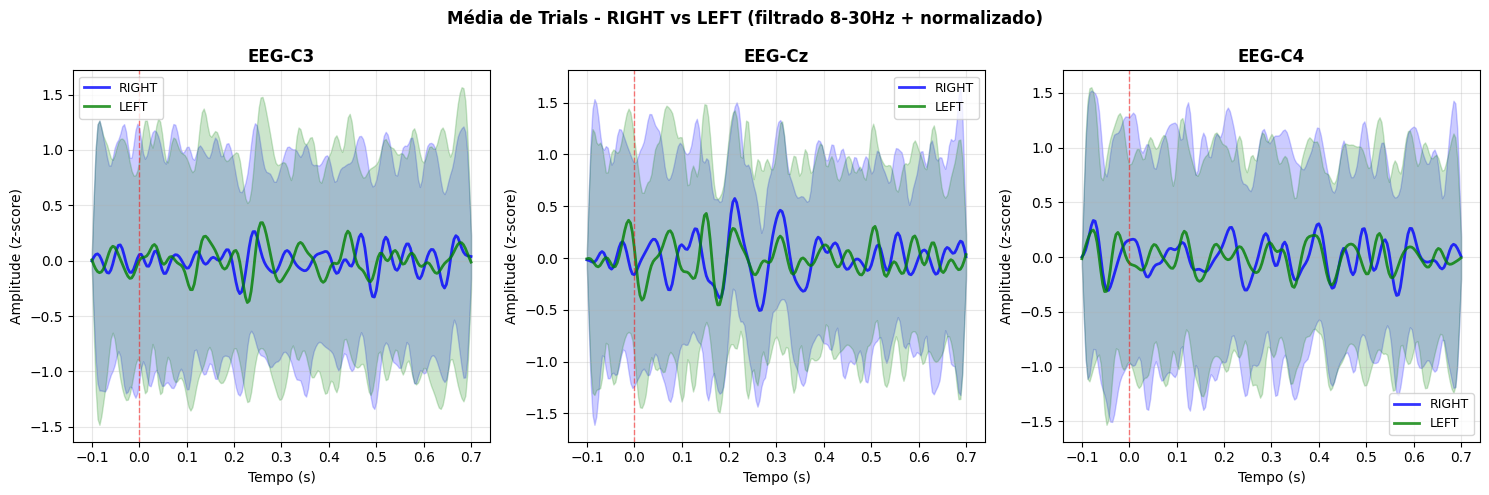

In [28]:
# Compare mean trials
time_axis = np.linspace(-0.1, 0.7, 201)

# Apply normalization if enabled (apenas para visualização)
mean_right_plot = mean_right.copy() if mean_right is not None else None
mean_left_plot = mean_left.copy() if mean_left is not None else None
std_right_plot = std_right.copy() if std_right is not None else None
std_left_plot = std_left.copy() if std_left is not None else None

if USE_NORMALIZATION and mean_right_plot is not None and mean_left_plot is not None:
    # Normalize to [0, 1] range for each channel (apenas para plot)
    for col_idx in range(mean_right_plot.shape[1]):
        min_val = min(mean_right_plot[:, col_idx].min(), mean_left_plot[:, col_idx].min())
        max_val = max(mean_right_plot[:, col_idx].max(), mean_left_plot[:, col_idx].max())
        range_val = max_val - min_val if max_val != min_val else 1
        
        mean_right_plot[:, col_idx] = (mean_right_plot[:, col_idx] - min_val) / range_val
        mean_left_plot[:, col_idx] = (mean_left_plot[:, col_idx] - min_val) / range_val
        std_right_plot[:, col_idx] = std_right_plot[:, col_idx] / range_val
        std_left_plot[:, col_idx] = std_left_plot[:, col_idx] / range_val

# Construir label descritivo
processing_label = "original"
if USE_FILTER and USE_DATA_NORMALIZATION:
    processing_label = f"filtrado {FILTER_LOW}-{FILTER_HIGH}Hz + normalizado"
elif USE_FILTER:
    processing_label = f"filtrado {FILTER_LOW}-{FILTER_HIGH}Hz"
elif USE_DATA_NORMALIZATION:
    processing_label = "normalizado"

normalization_label = f" - Normalizado para plot" if USE_NORMALIZATION else ""

fig, axes = plt.subplots(1, len(channels_to_plot), figsize=(15, 5))
fig.suptitle(f'Média de Trials - RIGHT vs LEFT ({processing_label}{normalization_label})', 
             fontsize=12, fontweight='bold')

if mean_right is not None and mean_left is not None:
    for idx, channel in enumerate(channels_to_plot):
        col_idx = eeg_columns.index(channel)
        ax = axes[idx]
        
        ax.plot(time_axis, mean_right_plot[:, col_idx], 'b-', linewidth=2, label='RIGHT', alpha=0.8)
        ax.fill_between(time_axis, mean_right_plot[:, col_idx] - std_right_plot[:, col_idx],
                         mean_right_plot[:, col_idx] + std_right_plot[:, col_idx], alpha=0.2, color='blue')
        
        ax.plot(time_axis, mean_left_plot[:, col_idx], 'g-', linewidth=2, label='LEFT', alpha=0.8)
        ax.fill_between(time_axis, mean_left_plot[:, col_idx] - std_left_plot[:, col_idx],
                         mean_left_plot[:, col_idx] + std_left_plot[:, col_idx], alpha=0.2, color='green')
        
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax.set_xlabel('Tempo (s)')
        
        if USE_DATA_NORMALIZATION:
            ax.set_ylabel('Amplitude (z-score)')
        elif USE_NORMALIZATION:
            ax.set_ylabel('Amplitude Normalizada')
        else:
            ax.set_ylabel('Amplitude (µV)')
        
        ax.set_title(channel, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)

plt.tight_layout()

if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'trials_mean_comparison.png', dpi=FIG_DPI, bbox_inches='tight')
    print(f"✓ Comparação de médias salva em 'trials_mean_comparison.png'")

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

✓ 6 trials LEFT salvos em 'trials_left.png'


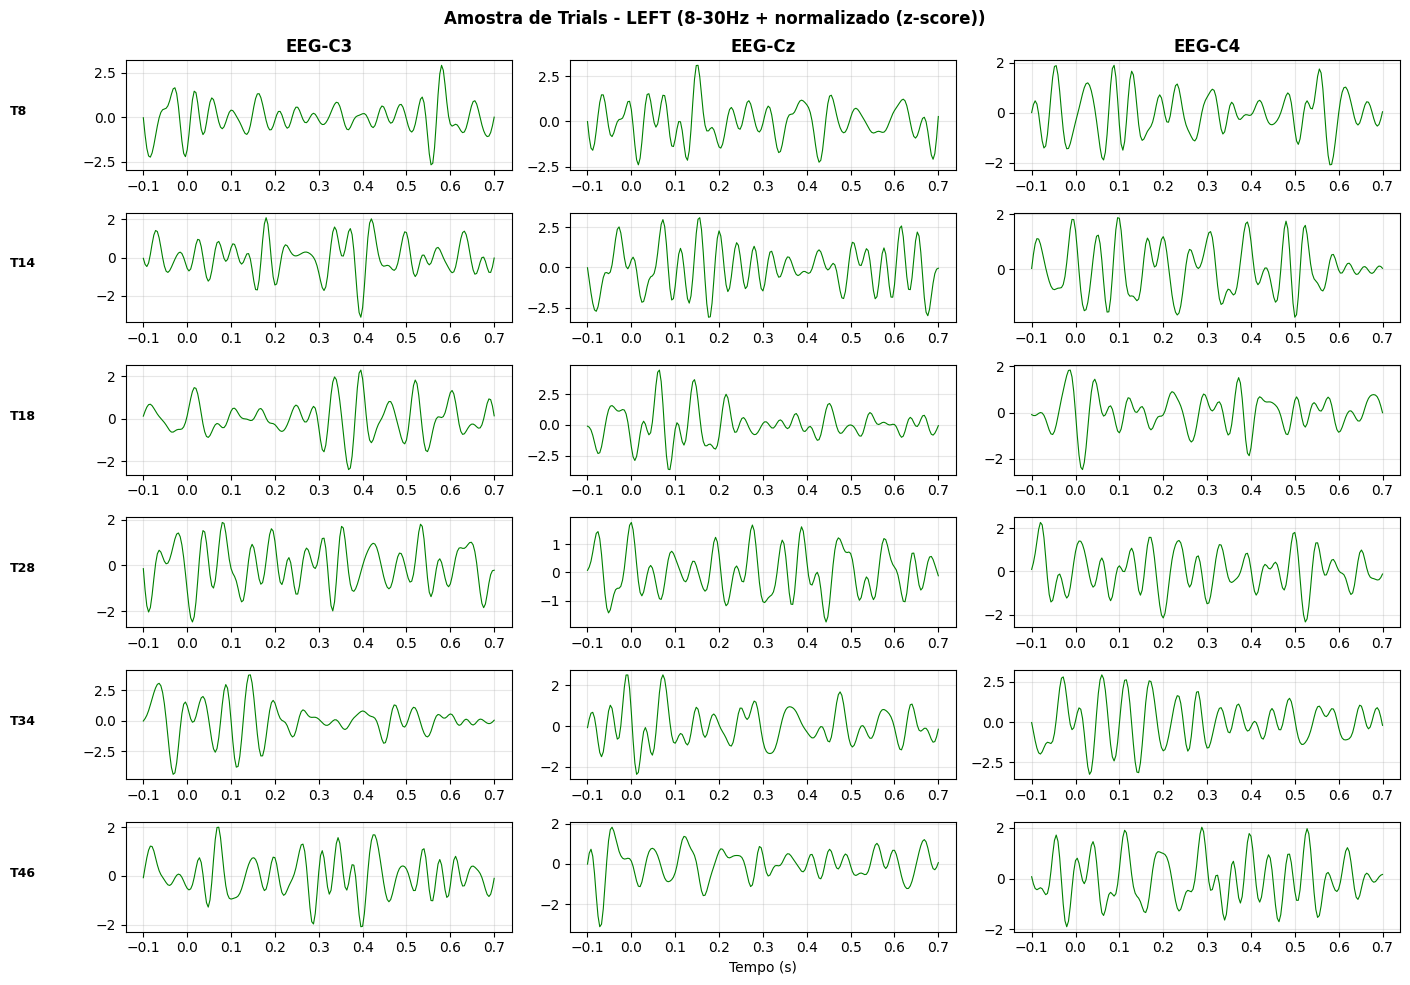

In [29]:
# Plot LEFT trials
fig, axes = plt.subplots(num_trials, len(channels_to_plot), figsize=(14, 10))

# Construir label descritivo
if USE_DATA_NORMALIZATION and USE_FILTER:
    processing_label = f"{FILTER_LOW}-{FILTER_HIGH}Hz + normalizado (z-score)"
elif USE_FILTER:
    processing_label = f"{FILTER_LOW}-{FILTER_HIGH}Hz"
elif USE_DATA_NORMALIZATION:
    processing_label = "normalizado (z-score)"
else:
    processing_label = "original"

fig.suptitle(f'Amostra de Trials - LEFT ({processing_label})', fontsize=12, fontweight='bold')

# Usar dados normalizados se disponível, senão filtrados
data_column = analysis_column_suffix

for row, epoch_id in enumerate(left_trials[:num_trials]):
    trial_data = trials[epoch_id]['data']
    for col_idx, channel in enumerate(channels_to_plot):
        ax = axes[row, col_idx]
        ax.plot(trial_data['time'], trial_data[channel + data_column], linewidth=0.8, color='green')
        ax.grid(True, alpha=0.3)
        if row == 0: ax.set_title(channel, fontweight='bold')
        if col_idx == 0: ax.text(-0.3, 0.5, f'T{epoch_id}', transform=ax.transAxes, fontsize=9, fontweight='bold')

axes[-1, 1].set_xlabel('Tempo (s)')
plt.tight_layout()

if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'trials_left.png', dpi=FIG_DPI, bbox_inches='tight')
    print(f"✓ {num_trials} trials LEFT salvos em 'trials_left.png'")

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

✓ 6 trials RIGHT salvos em 'trials_right.png'


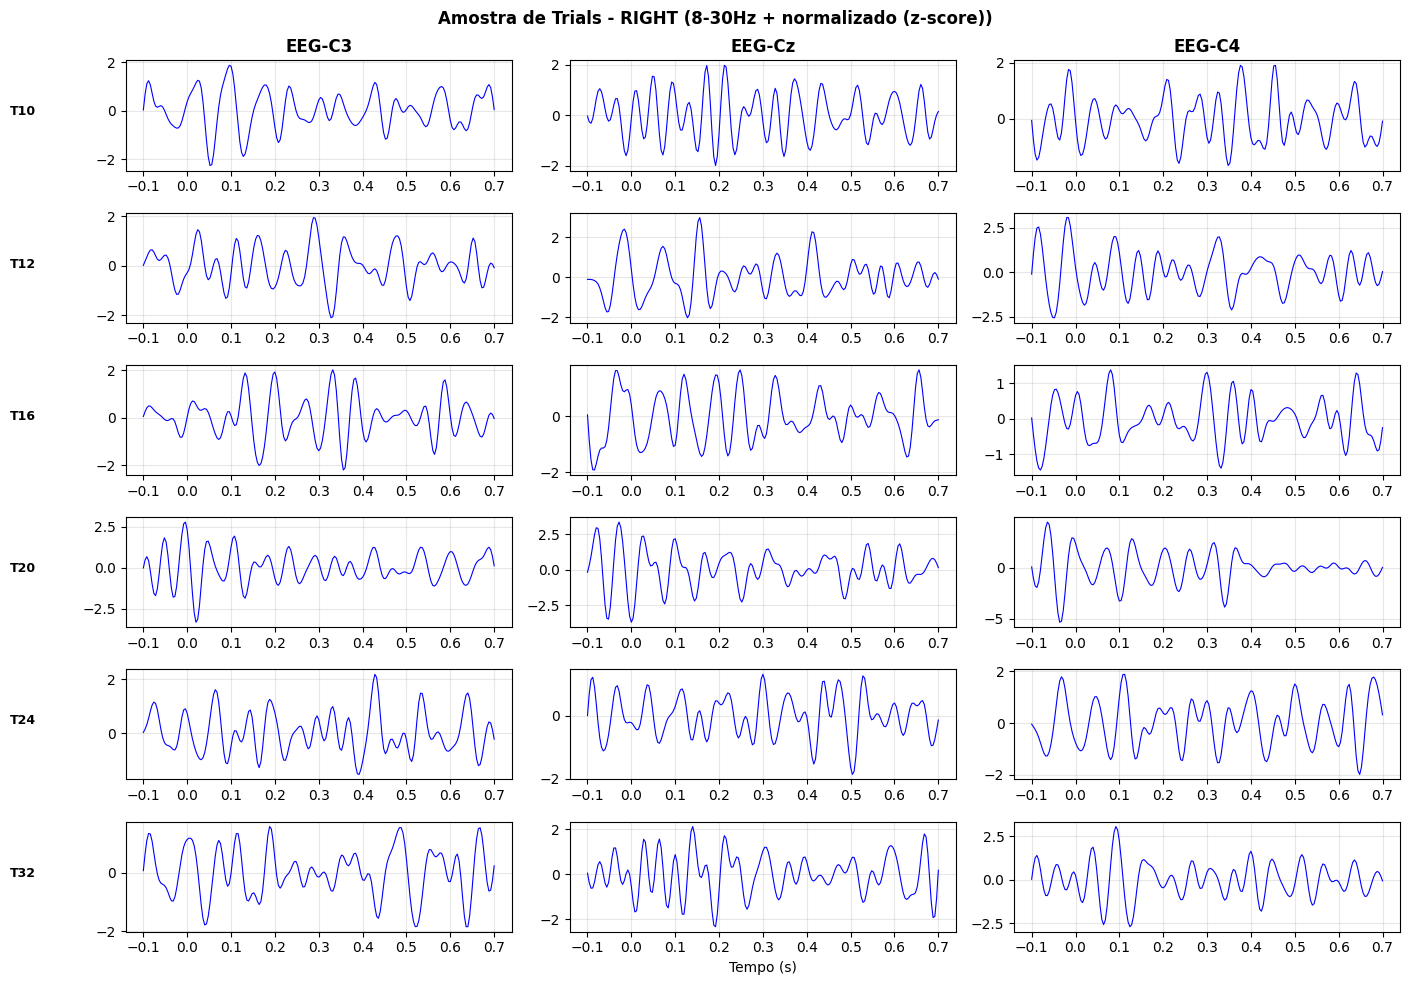

In [30]:
# Plot sample trials RIGHT
fig, axes = plt.subplots(num_trials, len(channels_to_plot), figsize=(14, 10))

# Construir label descritivo
if USE_DATA_NORMALIZATION and USE_FILTER:
    processing_label = f"{FILTER_LOW}-{FILTER_HIGH}Hz + normalizado (z-score)"
elif USE_FILTER:
    processing_label = f"{FILTER_LOW}-{FILTER_HIGH}Hz"
elif USE_DATA_NORMALIZATION:
    processing_label = "normalizado (z-score)"
else:
    processing_label = "original"

fig.suptitle(f'Amostra de Trials - RIGHT ({processing_label})', fontsize=12, fontweight='bold')

# Usar dados normalizados se disponível, senão filtrados
data_column = analysis_column_suffix

for row, epoch_id in enumerate(right_trials[:num_trials]):
    trial_data = trials[epoch_id]['data']
    for col_idx, channel in enumerate(channels_to_plot):
        ax = axes[row, col_idx]
        ax.plot(trial_data['time'], trial_data[channel + data_column], linewidth=0.8, color='blue')
        ax.grid(True, alpha=0.3)
        if row == 0: ax.set_title(channel, fontweight='bold')
        if col_idx == 0: ax.text(-0.3, 0.5, f'T{epoch_id}', transform=ax.transAxes, fontsize=9, fontweight='bold')

axes[-1, 1].set_xlabel('Tempo (s)')
plt.tight_layout()

if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'trials_right.png', dpi=FIG_DPI, bbox_inches='tight')
    print(f"✓ {num_trials} trials RIGHT salvos em 'trials_right.png'")

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut

# ============================================================================
# 1. CARREGAR DADOS E GERAR VETOR DE GRUPOS (NECESSÁRIO PARA LOSO)
# ============================================================================
print(f"📦 Carregando dataset completo para divisão LOSO...")

X_list = []
y_list = []
groups_list = [] # Armazena o ID do paciente para cada trial

# Garante configurações atuais
current_suffix = '_normalized' if locals().get('USE_DATA_NORMALIZATION', True) else '_filtered'

# Loop apenas para estruturar os dados (sem treino)
for p_id in range(1, 10):
    filename = f"BCICIV_2a_{p_id}.csv"
    file_path = DATA_DIR / filename
    
    if not file_path.exists(): continue
        
    df_temp = pd.read_csv(file_path)
    df_temp = df_temp[df_temp['label'].isin(['right', 'left'])].copy()
    
    # Identifica colunas
    if 'eeg_columns' not in locals():
        eeg_cols = [c for c in df_temp.columns if c.startswith('EEG-')]
    else:
        eeg_cols = eeg_columns

    # Stats para normalização (se ativado)
    patient_stats = {}
    if USE_DATA_NORMALIZATION:
        for col in eeg_cols:
            col_data = df_temp[col].values
            if USE_FILTER: col_data = bandpass_filter(col_data)
            patient_stats[col] = {'mean': np.mean(col_data), 'std': np.std(col_data)}

    # Extração das Épocas
    for epoch_id in df_temp['epoch'].unique():
        trial_data = df_temp[df_temp['epoch'] == epoch_id]
        if len(trial_data) == 0: continue
        
        y_label = 0 if trial_data['label'].iloc[0] == 'left' else 1
        
        # Monta matriz (Time x Channels)
        processed_channels = []
        for col in eeg_cols:
            raw = trial_data[col].values
            sig = bandpass_filter(raw) if USE_FILTER else raw
            if USE_DATA_NORMALIZATION:
                sig = normalize_eeg_channel(sig, mean=patient_stats[col]['mean'], std=patient_stats[col]['std'])
            processed_channels.append(sig)
            
        X_list.append(np.array(processed_channels).T)
        y_list.append(y_label)
        groups_list.append(p_id) # <--- Importante: Registra o dono deste trial

# Arrays Finais
X = np.array(X_list)
y = np.array(y_list)
groups = np.array(groups_list)

print(f"✓ Dados Prontos: X={X.shape}, y={y.shape}, Grupos={np.unique(groups)}")

# ============================================================================
# 2. DEFINIÇÃO DO SPLIT (LEAVE-ONE-SUBJECT-OUT)
# ============================================================================
loso = LeaveOneGroupOut()

print(f"\n✂️ Gerador de Split LOSO criado com sucesso.")
print(f"   Para usar, itere sobre: loso.split(X, y, groups=groups)\n")

# Exemplo de verificação (APENAS MOSTRA O FORMATO, SEM TREINO)
for fold_idx, (train_index, test_index) in enumerate(loso.split(X, y, groups=groups)):
    # Aqui você acessa os dados
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Identifica qual paciente ficou no teste
    test_subject = np.unique(groups[test_index])[0]
    
    print(f"   > Fold {fold_idx+1}: Treino com {len(train_index)} amostras | Teste no Paciente {test_subject} ({len(test_index)} amostras)")
    
    # <--- INSIRA SEU CÓDIGO DE TREINAMENTO AQUI ---

📦 Carregando dataset completo para divisão LOSO...
✓ Dados Prontos: X=(1296, 201, 22), y=(1296,), Grupos=[1 2 3 4 5 6 7 8 9]

✂️ Gerador de Split LOSO criado com sucesso.
   Para usar, itere sobre: loso.split(X, y, groups=groups)

   > Fold 1: Treino com 1152 amostras | Teste no Paciente 1 (144 amostras)
   > Fold 2: Treino com 1152 amostras | Teste no Paciente 2 (144 amostras)
   > Fold 3: Treino com 1152 amostras | Teste no Paciente 3 (144 amostras)
   > Fold 4: Treino com 1152 amostras | Teste no Paciente 4 (144 amostras)
   > Fold 5: Treino com 1152 amostras | Teste no Paciente 5 (144 amostras)
   > Fold 6: Treino com 1152 amostras | Teste no Paciente 6 (144 amostras)
   > Fold 7: Treino com 1152 amostras | Teste no Paciente 7 (144 amostras)
   > Fold 8: Treino com 1152 amostras | Teste no Paciente 8 (144 amostras)
   > Fold 9: Treino com 1152 amostras | Teste no Paciente 9 (144 amostras)


In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from mne.decoding import CSP

# ==============================================================================
# SCOLFIELD PROTOCOL: PIPELINE ANTI-VAZAMENTO PARA CSP-LDA
# ==============================================================================

# 1. Definição do Pipeline Blindado
# O Pipeline garante que o 'fit' (aprendizado) só ocorra no Treino.
# O Teste passa apenas pelo 'transform' usando os parâmetros aprendidos no Treino.
csp_lda_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normaliza (Z-score) baseado APENAS no treino
    ('csp', CSP(n_components=4, reg=None, log=True, norm_trace=False)), # Filtros espaciais
    ('lda', LDA()) # Classificador
])

# 2. Dados (Simulação baseada no seu notebook)
# X shape: (n_trials, n_channels, n_time_points)
# y shape: (n_trials,) -> Labels
# groups shape: (n_trials,) -> ID do Paciente para cada trial
print(f"Iniciando Validação Cruzada (Leave-One-Subject-Out)...")

# 3. Validação Cruzada Correta
cv = LeaveOneGroupOut()
scores = []

# Iteração manual para controle total e auditoria
for train_idx, test_idx in cv.split(X, y, groups=groups):
    # Separação ESTRITA dos dados
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # O pipeline faz a mágica:
    # a) scaler.fit(X_train) -> Calcula média/std do treino
    # b) csp.fit(X_train) -> Aprende filtros espaciais do treino
    # c) lda.fit(features_train) -> Treina classificador
    csp_lda_pipeline.fit(X_train, y_train)
    
    # No teste, ele usa a média/std e filtros DO TREINO.
    # Se o desempenho cair aqui, é a acurácia REAL, sem vazamento.
    score = csp_lda_pipeline.score(X_test, y_test)
    scores.append(score)
    
    subject_id = np.unique(groups[test_idx])[0]
    print(f" > Sujeito {subject_id}: Acurácia = {score:.2%}")

print(f"\n[RESULTADO FINAL] Acurácia Média: {np.mean(scores):.2%} +/- {np.std(scores):.2%}")

Iniciando Validação Cruzada (Leave-One-Subject-Out)...


ValueError: Found array with dim 3, while dim <= 2 is required by StandardScaler.

: 